# Project 04 - Bayesian Blocks Algorithm
_Diego Bonato, Martina Cacciola_ - Advanced Statistics for Physics Analysis (A.A. 2022/23)

## Abstract

The Bayesian Blocks algorithm offers a way to improve the binning process of histograms by finding the optimal segmentation of the data in the observation interval. The advantage is its ability to create histograms that faithfully capture the underlying distribution of the data, by separating statistically significant features from random observational fluctuactions. In this project, we have implemented the Bayesian Blocks algorithm in R and assessed its effectiveness by testing it on different datasets to see how well it performs.

## 1. Representation of Data: Histograms

One of the most common ways to depict data distributions are histograms. Typically, a range and bin width are subjectively chosen to create visually appealing plots. The outcome of using various approaches is that, in case of data described by the same statistics, the resulting plots could stress different features leading to disparate interpretations.

Objective techniques have been proposed, like Scott's Rule<sup><a href="#ref1">[1]</a></sup>, which optimizes binning for random samples with a normal distribution. Knuth's Rule<sup><a href="#ref1">[2]</a></sup> considers the structure of the distribution to build bins but uses fixed width. The "equal population" method aims for uniform entry counts per bin, with arbitrary choices for bin edges. However, existing methods have limitations.

In contrast, the **Bayesian Blocks algorithm**<sup><a href="#ref1">[3]</a></sup><sup><a href="#ref1">[4]</a></sup> treated in our work introduces variable bin widths and determines bin edges solely based on the data.

<a id="ref1">[1]</a> D. W. Scott, Biometrika 66, 605 (1979) \
<a id="ref1">[2]</a> K. H. Knuth, (2006), arXiv:physics/0605197[physics.data-an] \
<a id="ref1">[3]</a> J. D. Scargle, Studies in Astronomical Time Series Analysis. V. Bayesian Blocks, a New Method to Analyze Structure in Photon Counting Data, 1998, arXiv:astro-ph/9711233. \
<a id="ref1">[4]</a> J. D. Scargle, J. P. Norris, B. Jackson, and J. Chiang, Astrophys. J. 764, 167 (2013), arXiv:1207.5578[astro-ph.IM]

## 2. Bayesian Blocks

The Bayesian Blocks algorithm serves as a non-parametric modeling technique, revealing local structures within background data through the comprehensive use of data information. While its development initially targeted time series in astronomy, the algorithm's goal extends to various types of sequential data or any independent variable. In this work, we focus on one-dimensional data.

The algorithm employs a "Piecewise Constant Model": it consists in dividing the range of the independent variable (i.e. time) into `blocks` of variable size, gapless and non-overlapping. A block holds 1 to N data points, with the sum of block contents equaling N. The intensity is modeled as constant within each block, containing consecutive data elements satisfying some well-defined criterion. The optimal segmentation maximizes a quantitative expression of this criterion.

Three main data types are considered:

1. **Events (TTE)**: Time of measurements.
2. **Binned Events**: Event counts in time bins.
3. **Point Measurements**: Continuous observations at sequential time points.

By optimizing a fitness statistic and a regularization parameter, the algorithm computes the number of bins and their edges (`change points`), points in which the model parameters undergo discrete jumps. The fitness represents a measure of how well a constant signal represents the data within the block.
The fitness of the total dataset is the sum of individual block fitness, relying on their additivity:

$$F_{total} = \sum_{i=1}^{K} f(B_i)$$

The fitness function varies based on data type.

## 3. Prior for the Number of Blocks
In Scargle (1998) <sup><a href="#ref1">[3]</a></sup>, there was no explicit definition of a prior probability distribution for the number of blocks $N_{blocks}$: this leads to a flat prior, which turns out unreasonable in many contexts. In most settings, it is much more likely a prior for which $N_{blocks} << N$, than $N_{blocks} \approx N$, with $N$ being the number of data points. For this reason, it was adopted a `geometric prior` with parameter $\gamma$:
$$P(N_{blocks}) = P_0 \gamma^{N_{blocks}} $$

where $P_0$ is the normalization constant, which, once obtained, gives:

$$P(N_{blocks}) = \frac{1-\gamma}{1-\gamma^{N+1}} \gamma^{N_{blocks}}$$
and the expected number of blocks is:

$$ <N_{blocks}> = P_0 \sum_{N_{blocks}}^{N} N_{blocks} \gamma^{N_{blocks}} = \frac{N\gamma^{N+1}+1}{\gamma^{N+1}-1} + \frac{1}{1-\gamma}  $$

The choice of the parameter $\gamma$ affects the visual representation since it is linked to $N_{blocks}$ in the optimal partitioning. In general, the results are rather insensitive to the value as long as the signal-to-noise ratio is moderately large. When considering extreme values of
$\gamma$, the algorithm produces unsatisfactory results, in the form of clearly too few or too many blocks. In selecting a value to use in applications, the tradeoff lies between a conservative choice, unaffected by noise fluctuations but potentially missing real changes, and a liberal choice, effectively capturing changes but introducing false detections  (eventually reaching the limit of $N_{blocks}=N$).
In almost all applications, $\gamma$ will be chosen $<1$ to express that a smaller number of blocks is a priori more likely than a larger number.

In Scargle et al.<sup><a href="#ref1">[4]</a></sup> it has been presented an objective method to implement `ncp_prior` as a function of the number of data points $N$. The procedure uses the fact that `ncp_prior` controls the _correct detection rate_ $p_0$, i.e. the frequency at which the algorithm correctly rejects the presence of a change point. The calibration of `ncp_prior` is based on extensive simulations performed by Scargle et al.<sup><a href="#ref1">[4]</a></sup> for a wide range of $N$ and $p_0$. The results were found to fit well with the following formula:

$$ \text{ncp_prior}  = 4 - log(75.53 p_0 N^{-0.478})$$

## 4.1 Fitness

### 4.1.1  Events

To comprehend the fitness function, we start with the unbinned log-likelihood referred to as the Cash statistic <sup><a href="#ref1">[5]</a></sup>:

$$\log L(\theta) = \sum_{n} \log M (t_n, \theta) - \int M (t, \theta)dt$$

In this equation where we sum over the events, $M(t, \theta)$ represents a model of the signal's time dependence and $\theta$ the model parameters. The integral is the expected number of events under the model, over the observation interval. Once we consider each $k$-th block model as constant, it possesses a single parameter $M(t, \lambda) = \lambda$, leading to the following log-likelihood:

$$\log L^{(k)}(\lambda) = N^{(k)}\log \lambda - \lambda T^{(k)}$$

where $N^{(k)}$ indicates the number of events in the $k$-th block, and $T^{(k)}$ is the block's length. When $\lambda = \frac{N^{(k)}}{T^{(k)}}$, the fitness is maximized, resulting in:

$$\log L^{(k)}_{\max} +  N^{(k)} = N^{(k)}(\log N^{(k)} - \log T^{(k)})$$

Since the sum of $N^{(k)}$ remains constant across $k$, it is independent of the model and thus irrelevant.

<a id="ref1">[5]</a> W., Parameter-Estimation in Astronomy through Application of the Likelihood Ratio, Astrophysical Journal.


### 4.1.2 Point Measurements
A common experimental scenario is to measure a signal $s(t)$ at a sequence of times $t_n, n = 1, 2, . . . , N$, known as `sampling`, in order to characterize its time dependence.
Inevitable corruption due to observational errors is frequently countered by smoothing the data and/or fitting a model.
As with the other data modes Bayesian Blocks is a different approach to this issue, making use of knowledge of the observational error distribution and avoiding the information loss entailed by smoothing.
We assume that the measurements at these times are independent of each other, which is to say the errors of observation are statistically independent. </br>
These errors are stochastic and additive, so that the measured time series can be modeled as:

$$\large x_n \equiv x(t_n) = s(t_n) + z_n$$

The error $z_n$ at time $t_n$ is known only by its statistical distribution. Let us consider $z_n \sim \mathcal{N}(0, \sigma_n)$. If we model the signal as a constant $s = \lambda$, the likelihoood of the $n$-th measurement is:

$$ \large L_n = \frac{1}{\sigma_n \sqrt{2 \pi}} e^{- \frac{1}{2} \left( \frac{x_n - \lambda}{\sigma_n}\right)^2}$$

So, since we assume the indipendence of the measurements, the block $k$ likelihood is:

$$\large L^{(k)} = \prod_n L_n = \frac{(2 \pi)^{- \frac{N_k}{2}}}{\prod_m \sigma_m} e^{-\frac{1}{2} \sum_n \left( \frac{x_n - \lambda}{\sigma_n}\right)^2}$$

The quantity multiplying the exponential in the above equation is irrelevant because it contributes an overall constant factor to the total likelihood.</br>
From the computation in the paper<sup><a href="#ref1">[3]</a></sup>, the maximum log-likelihood is expressed as:

$$\large \log L^{(k)}_{\max} = b_{k}^{2}/4 a_k$$

where $a_k$ and $b_k$ are defined as follows:

$$ a_k = \frac{1}{2} \sum_n \frac{1}{\sigma^2_n}$$
$$ b_k = \frac{1}{2} \sum_n \frac{x_n}{\sigma^2_n}$$

## 5. Implementation of the Algorithm
### 5.1 Description
The algorithm follows the spirit of mathematical induction: starting from the first data cell, at each step one more cell is added.
Let $\mathcal{P}^{opt}(R)$ denote the optimal partition of the first $R$ cells. In the starting case $R= 1$, the only possible partition is trivially optimal. Now assume we have completed step $R$, identifying the optimal partition $\mathcal{P}^{opt}(R)$. At this (and each previous) step, the value of optimal fitness itself is stored in array `best` and the location of the last change point of the optimal partition is stored in array `last`.
It remains to explain how to obtain $\mathcal{P}^{opt}(R+1)$. It can be shown that removing the last block of an optimal partition leaves an optimal partition. This allows to iteratively consider an increasing number of data points and at each step compute the optimum partition for them.

During iteration $n$ (where data point $n$ is being evaluated), the potential total fitnesses are calculated as:
$$
F_{total} (n,m) = F_m + f(B_m^n), \quad m=1,2,\dots,n-1
$$

where $F_m$ is the optimal fitness as determined during iteration $m$, and $f(B_m^n)$ is the fitness of the block bound between data points $n$ and $m$.

This fitness is calculated $n − 1$ times at each iteration, and the maximum of those fitnesses along with the relevant change-points are stored and used during the subsequent iterations.
The iterations continue until the whole interval has been analyzed. After the final iteration $N$, the change-points associated with the maximum total fitness are returned.

### 5.2 Code
Below is reported the code for the implementation of the Bayesian Blocks algorithm written in R and based both on the MATLAB code presented in Scargle et al. <sup><a href="#ref1">[4]</a></sup> and the Astropy code <sup><a href="#ref1">[6]</a></sup>.

<a id="ref1">[6]</a> https://docs.astropy.org/en/stable/api/astropy.stats.bayesian_blocks.html

In [37]:
# Uncomment this if running from Google Colab

#install.packages("tidyverse")
#install.packages("emdbook")
#install.packages("latex2exp")
#install.packages("FITSio")

In [38]:
library(tidyverse)
library(emdbook)
library(latex2exp)
library(FITSio)


### Validate input

In [39]:
validate.input = function(data, data_type='Events'){

    cells = data

    #using the data.frame structure
    if (!is.data.frame(cells)){

        cells = as.data.frame(cells)
    }

    if (data_type=='Events'){
        #count the number of times an event is registered

        data = table(cells)
        x_unique = as.numeric(names(data))
        x_weight = as.numeric(data)

        data = data.frame(x_unique, x_weight)

        data = data[order(data$x_weight), ]
        return(data)
    }

    if (data_type=='BinnedEvents'){
       # In each tick, there are either zero or one counts.
        #sorting along times
        return(cells[order(cells[[1]]), ])
    }

    if (data_type=='PointMeasures'){
        #sorting along times

        return(cells[order(cells[[1]]), ])
    }

}

### Prior computation

In [40]:
compute.ncp_prior = function(gamma=NULL, N, p0 = .05, data_type = "Events"){

    if (is.null(gamma)){

      if(data_type == "Events"){
         return(4 - log(73.53 * p0 * (N**-0.478)))

      }
    }

    if(data_type == "PointMeasures"){
      return( 1.32 + 0.577 * log10(N))
    }

    else{
        return(-log(gamma))
    }
}

### Fitness computation

In [41]:
compute.fitness = function(count_vec, width, dt=NULL, a_k=NULL, b_k=NULL, data_type='Events'){

    if (data_type=='Events'){

        return(count_vec* (log(count_vec / width)))
    }
    else if (data_type=='BinnedEvents'){
        M = width/dt
        count_vec_over_M = count_vec/M

        esp = 1e-8
        if (sum(count_vec_over_M > 1+esp) > 0){
            cat("regular events: N/M > 1.  Is the time step correct?")
            break
        }

        one_m_NM = 1 - count_vec_over_M
        count_vec_over_M[count_vec_over_M <= 0] = 1
        one_m_NM[one_m_NM <= 0] = 1

        return(count_vec * log(count_vec_over_M) + (M  - count_vec)*log(one_m_NM))
    }
    else if(data_type=='PointMeasures'){
        return( (b_k*b_k)/(4*a_k) )
    }

}

### Algorithm function

In [42]:
bayesian_blocks = function(data, ncp_prior=NULL, gamma=NULL, dt=NULL, data_type='Events'){

    cells = validate.input(data, data_type)

    t = cells[[1]]
    x = cells[[2]]


    if (length(data)==3){sigma = cells[[3]]} #length(data) returns the number of columns of the dataframe
    else{sigma = 1}
    N = length(t)



    #quantities needed for the computation of a_k, b_k
    ak_raw = rep(x = 1, times=length(x))/sigma**2
    bk_raw = x/sigma**2
    #ck_raw = (x*x)/sigma**2

    edges = c(t[1],  0.5 * (t[2:length(t)] + t[1:(length(t)-1)] ), t[length(t)])
    block_length = t[length(t)] - edges

    best = rep(0, times = N)
    last = rep(1, times = N)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------

    for (K in seq(1:N)){
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[1:K] - block_length[K + 1] #T_K
        count_vec = rev(cumsum(rev(x[1:K]))) #N_K

        # count_vec <- rev(cumsum(x_weight[1:R]))

        a_k = NULL
        b_k = NULL

        if (is.null(ncp_prior)){
            ncp_prior = compute.ncp_prior(gamma, N)
        }

        if (data_type !='Events' ){
            a_k = 0.5*rev(cumsum(rev(ak_raw[1:K])))
            b_k = -1 * rev(cumsum(rev(bk_raw[1:K])))
        }


        fit_vec = compute.fitness(count_vec = count_vec, width = width, a_k=a_k, b_k=b_k, dt=dt, data_type)

        post_vec = fit_vec - ncp_prior

        post_vec[2:length(post_vec)] = post_vec[2:length(post_vec)] + best[1:(K-1)]

        i_max = which.max(post_vec)


        last[K] = i_max
        best[K] = post_vec[i_max]

    }

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------

    change_points =  rep(1, times=N)
    i_cp = N
    ind = N+1

    while (i_cp>1){
        change_points[i_cp] = ind
        if (ind == 1){ break }
        i_cp = i_cp-1
        ind = last[ind - 1]
    }

    if (i_cp==1){change_points[i_cp] = 1}
    change_points = change_points[i_cp:length(change_points)]

    return(edges[change_points])
}

### Computational time

The number of possible partitions (i.e., the number of ways $N$ cells can be arranged in blocks) is $2^N$ . This number is exponentially large, rendering an explicit exhaustive search of partition space utterly impossible for all but very small $N$. Our algorithm implicitly performs a complete search of this space in time of order $N^2$. The beauty of the algorithm is that it finds the optimum among all partitions without an exhaustive explicit search, which is obviously impossible for almost any value of $N$ arising in practice.

We computed the computational time taken by the algorithm to complete the instructions over a set of randomly generated data, until the determination of the blocks' edges. The algorithm has been run 10 times to add some statistics and calculate the error bars as $\sigma/\sqrt{n}$. The errors tend to become larger, because to get a more precise value it might be better to increase the number of runs.

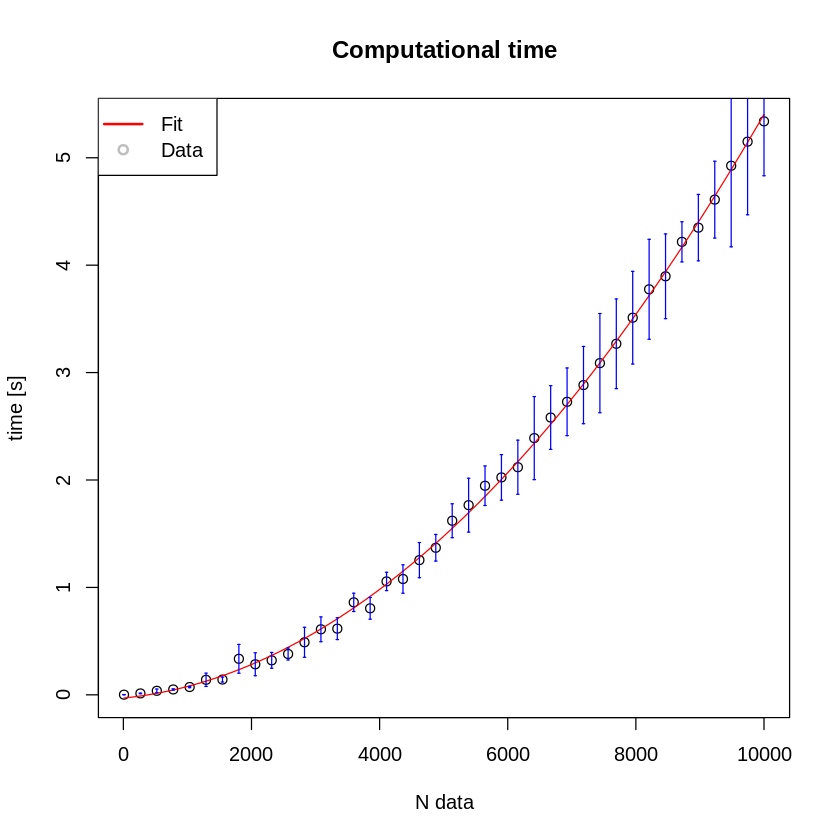

In [43]:
time = read.csv("data/errorbars.csv")

x = seq(10,1e4,length.out = 40)
y = time$means
errors = time$std

# Create a quadratic model
quadratic_model = lm(y ~ x + I(x^2))

# Extract coefficients
coefficients = coef(quadratic_model)

# Plot original data
plot(x, y, main="Computational time", xlab="N data", ylab="time [s]")

# Add quadratic curve
curve(coefficients[1] + coefficients[2]*x + coefficients[3]*x^2, add=TRUE, col="red")
arrows(x, y - errors, x, y + errors, angle=90, code=3, length=0.01, col="blue")
legend("topleft", legend = c("Fit","Data"), col = c("red", "grey"), lty = c(1, NA), lwd = c(2, 2), pch = c(NA, 1))

## 5.2.1 Synthetic data
The Bayesian Blocks has been tested first on two synthetic datasets of `Events` type of data, generated under the uniform and normal distribution respectively.
In the case of the uniform sampling, it is clear how the algorithm is not being fooled by any fluctuation and is correctly recognizing the flat behaviour of the data. Moreover, when simulating different normal distributions with varying means and standard deviations, the algorithm is able to capture efficiently significant changes in the intensity of events.

## Uniform Distribution

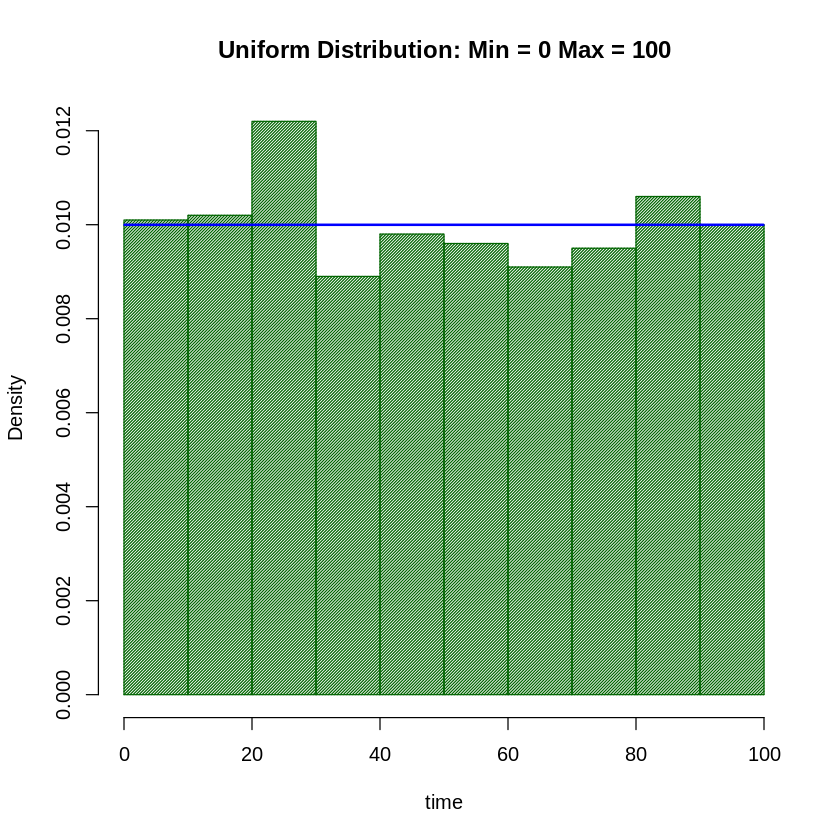

In [44]:
t.uniform = runif(1000, min = 0, max = 100)
x.uniform = rep(1, 1000)
edges.uniform = bayesian_blocks(t.uniform)

N.uniform = length(t.uniform)
N.edges.uniform = length(edges.uniform)

steps.uniform = rep(0, length(N.edges.uniform))

for (K in seq(1: N.edges.uniform)) {
    steps.uniform[K] = sum(x.uniform[t.uniform >= edges.uniform[K] & t.uniform < edges.uniform[K + 1]]) / sum(x.uniform * (edges.uniform[K + 1] - edges.uniform[K]))
    if (K == N.edges.uniform - 1) { break }
}
steps.uniform[N.edges.uniform] = steps.uniform[N.edges.uniform - 1]

hist(t.uniform, probability = TRUE, col = "darkgreen", density = 60,
     main = paste("Uniform Distribution: Min =", min(floor(t.uniform)), "Max =", max(ceiling(t.uniform))),
     xlab = "time")
lines(edges.uniform, steps.uniform, type = "s", lwd = 2, col = "blue")

## Normal distribution

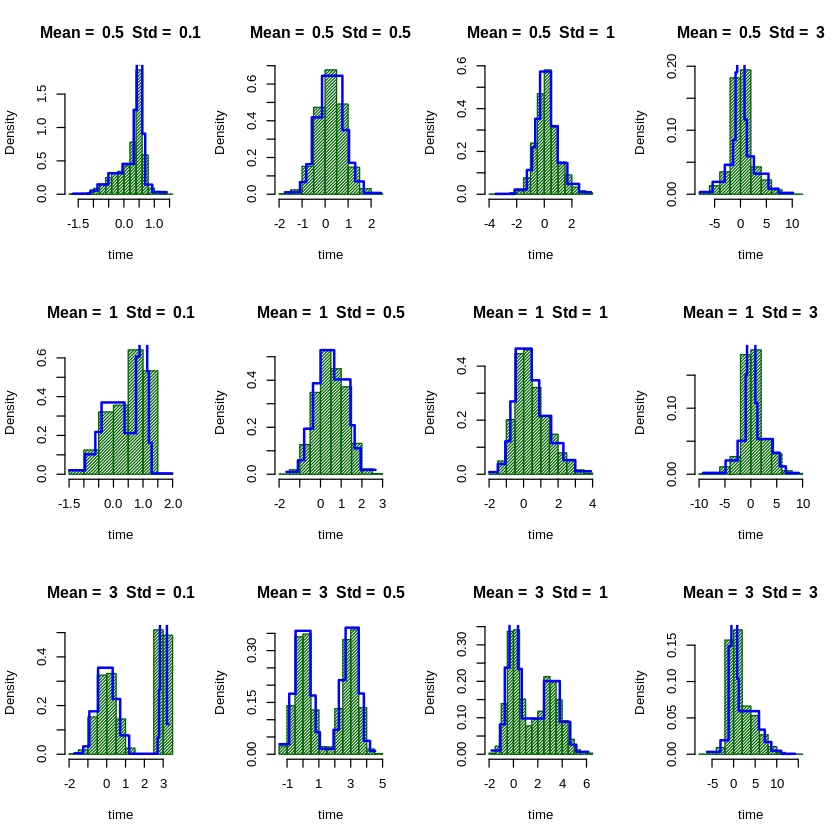

In [45]:
par(mfrow = c(3,4))
mean = c(.5,1,3)
std = c(.1,.5,1,3)



for (m in mean){
    for (s in std){



        t.normal = c(rnorm(mean = 0, sd =0.5, n = 1000 ),rnorm(mean = m, sd =s, n = 1000 ))
        x.normal = rep(1, 2000)


        edges.normal = bayesian_blocks(t.normal)
        N.normal = length(t.normal)
        N.edges.normal = length(edges.normal)


        steps.normal = rep(0, length(N.edges.normal))

            for (K in seq(1: N.edges.normal)){

                steps.normal[K] = sum(x.normal[t.normal>=edges.normal[K] & t.normal<edges.normal[K+1]])/sum(x.normal*(edges.normal[K+1] -edges.normal[K]))

                if (K==N.edges.normal-1){break}
            }
        steps.normal[N.edges.normal] = steps.normal[N.edges.normal-1]


        hist(t.normal,probability = TRUE,col="darkgreen",density=60, main= paste("Mean = ",m," Std = ", s), xlab="time")
        lines(edges.normal, steps.normal, type = "s", lwd = 2, col = "blue")

        }
    }

## Applications

## 5.2.2  BATSE Time-Tagged Events

We reproduce the example presented in Scargle et al.<sup><a href="#ref1">[4]</a></sup> about a collection of raw TTE data at the Burst and Transient Source Experiment (BATSE) <sup><a href="#ref1">[7]</a></sup>. The files consist in time tags for all photons detected in the gamma-ray burst. In particular, we show data from an energy channel of the Trigger 551 in the 4B catalog. It is a simple example of analysis of this type of data, since the trigger presents moderate pulse structure.
In the histogram, the number of bins follow the common approach of taking $\sqrt{N}$, with $N$ being the number of blocks. The overall behavior is consistent to what observed in the paper.

<a id="ref1">[7]</a> ftp://legacy.gsfc.nasa.gov/compton/data/batse/ascii_data/batse_tte/

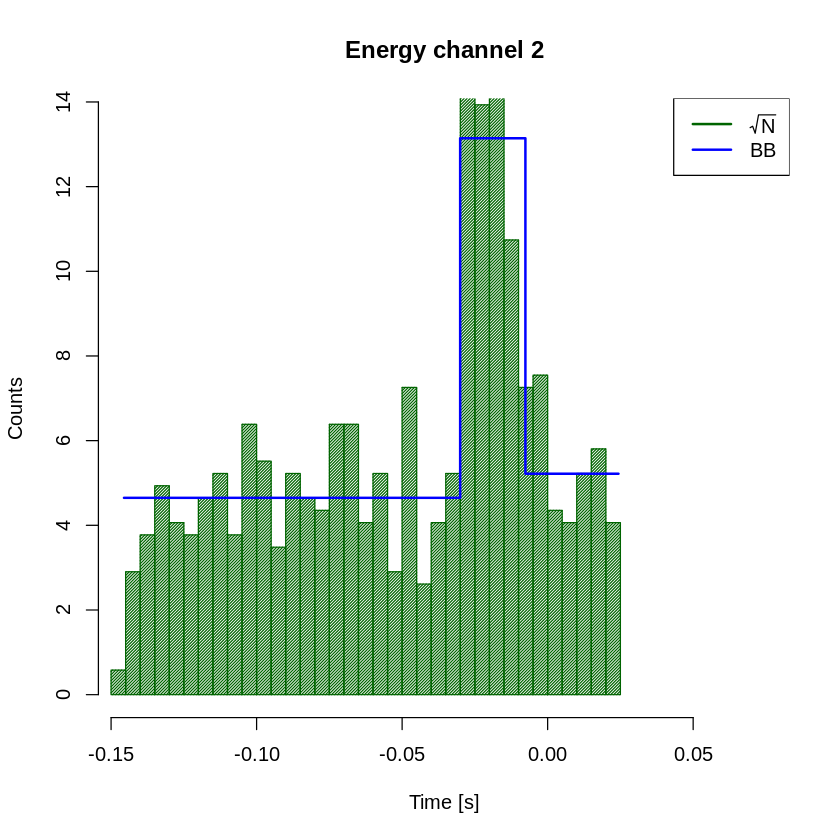

In [46]:
energy = read_csv("data/Energy_channel_2.csv",show_col_types = FALSE)


energy_channel = as.numeric(energy[[1]])
x = rep(1, length.out = length(energy_channel))
edges = bayesian_blocks(energy_channel)

N = length(energy_channel)
N.edges = length(edges)


steps = rep(0, length(N.edges))
    for (K in seq(1: N.edges)){

        steps[K] = sum(x[energy_channel>=edges[K] & energy_channel<edges[K+1]])/sum(x*(edges[K+1] - edges[K]))

        if (K==N.edges-1){break}
    }
steps[N.edges] = steps[N.edges-1]

hist(energy_channel,probability = TRUE,col="darkgreen",density=60, main="Energy channel 2",xlim=c(min(energy_channel),max(energy_channel)+.05),ylim = c(0,max(steps)+.4), xlab='Time [s]',ylab='Counts',breaks=sqrt(length(energy_channel)),alpha=0.5)
lines(edges, steps , type = "s", lwd = 2, col = "blue")
legend("topright", legend = c(expression(sqrt(N)), "BB"), col = c("darkgreen", "blue"), lty = c(1, 1), lwd = c(2, 2))

## 5.2.3 Light curve for Millisecond Pulsar

We apply the algorithm in the context of optical spectroscopic and photometric observations of PSR J2215+5135, a binary millisecond pulsar (MSP) <sup><a href="#ref1">[8]</a></sup>.

New MSPs in compact binaries provide a good opportunity to search for the most massive neutron stars. Their main-sequence companion stars are often strongly irradiated by the pulsar, displacing the effective center of light from their barycenter and making mass measurements uncertain.

It can be seen that the algorithm is identifying a central block significantly larger with respect to the others. It could indicate a significant and prolonged event that has a substantial impact on the observed flux. While the exact interpretation would depend on the specific characteristics of the light curve and the context of the observation, some potential explanations can be:

* **Flare or Outburst**: in binary systems, sudden increases in brightness can occur due to enhanced emission from the pulsar, its companion, or the interaction between the two. Flares or outbursts can result from accretion processes or other dynamic interactions within the system;

* **Significant Irradiation**: if the companion star is strongly irradiated by the pulsar, its effective center of light may shift. Thus, what we observe can be a period of intense irradiation or a change in the irradiation pattern. This could affect the observed flux and indicate variations in the system's behavior.

* **Magnetic Activity**: pulsars are known for their strong magnetic fields, and variations in magnetic activity can lead to an increase in the emission.


<a href="#ref1">[8]</a>
Kennedy, M. R., Voisin, G., Breton, R. P., Clark, C. J., & Mata-Sánchez, D. (2020). Optical light curve of PSR J2215+5135 [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3894748

In [47]:
#importing optical light curve data
olc = read.table('data/20140811_G_flux.dat')

In [48]:
#cleaning the dataframe
olc_clean <- olc[, c(3, 4)]
colnames(olc_clean) <- c("flux", "flux_error")

#selecting flux and error columns
data = data.frame("t" = 1:length(olc_clean$flux), "x" = olc_clean$flux, "sigma" = olc_clean$flux_error)

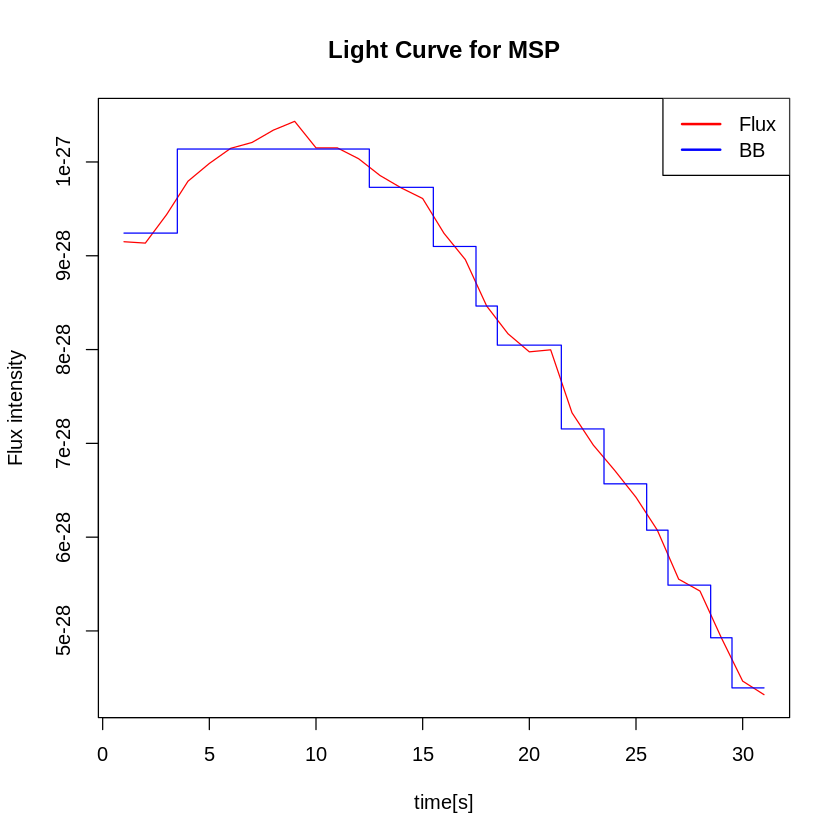

In [49]:
#counting mean over edges

edges = bayesian_blocks(data = data, data_type = 'PointMeasures')

steps = rep(0, length(edges))

for (K in seq(1:length(edges))){

    steps[K] = mean(data$x[data$t>=edges[K] & data$t<=edges[K+1]])
    if (K==(length(edges)-1)){break}
}

steps[length(edges)] = steps[length(edges)-1]

steps[length(edges)] = steps[length(edges)-1]
plot(data$t,data$x,col="red",density=60, main="Light Curve for MSP", type='l',xlab="time[s]",ylab="Flux intensity" )
lines(edges, steps , type = "s", lwd = 1, col = "blue")
legend("topright", legend = c("Flux","BB"), col = c("red", "blue"), lty = c(1, 1), lwd = c(2, 2))

## 5.2.3 Exoplanet time series

We then focus on time series collected by Kepler, a NASA satellite-telescope designed to search for exoplanets <sup><a href="#ref1">[8]</a></sup>. It is very sensitive to changes in flux (light intensity): it can be used to search for the presence of exoplanets in case the observed star undergoes to a regular **"dimming" of the flux**.
The data at our disposal consist in the change in flux of several thousand stars. Each star has a binary label of `1` or `2`. `2` indicates that that the star is confirmed to have at least one exoplanet in orbit.

In our scenario, the algorithm does not work well since it produces $N_{blocks} \simeq N$, where $N$ is the number of data points. This might occur if the star's flux data is characterized by sparse observations, irregular variations, or noise that the algorithm interprets as significant features.

To mitigate overfitting, it is important to carefully consider the data characteristics, the choice of block size prior, and possibly apply additional filtering or smoothing techniques.


<a id="ref1">[8]</a> https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data

In [50]:
exo = read_csv("data/exoTest.csv")

#selecting the stars with one exoplanet in orbit
transit = exo %>%
        filter(LABEL == 2)

planet = as.numeric(transit[5,-1])

Rows: 270 Columns: 3198
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3198): LABEL, FLUX.1, FLUX.2, FLUX.3, FLUX.4, FLUX.5, FLUX.6, FLUX.7, F...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [51]:
#removing outliers
planet = planet[planet > -500]

planet = planet[round(seq(1,length(planet),length.out = 100))]

data = data.frame("t" = 1:length(planet), "x" = planet, "sigma" = rep(1 / sqrt(length(planet)),length(planet)))

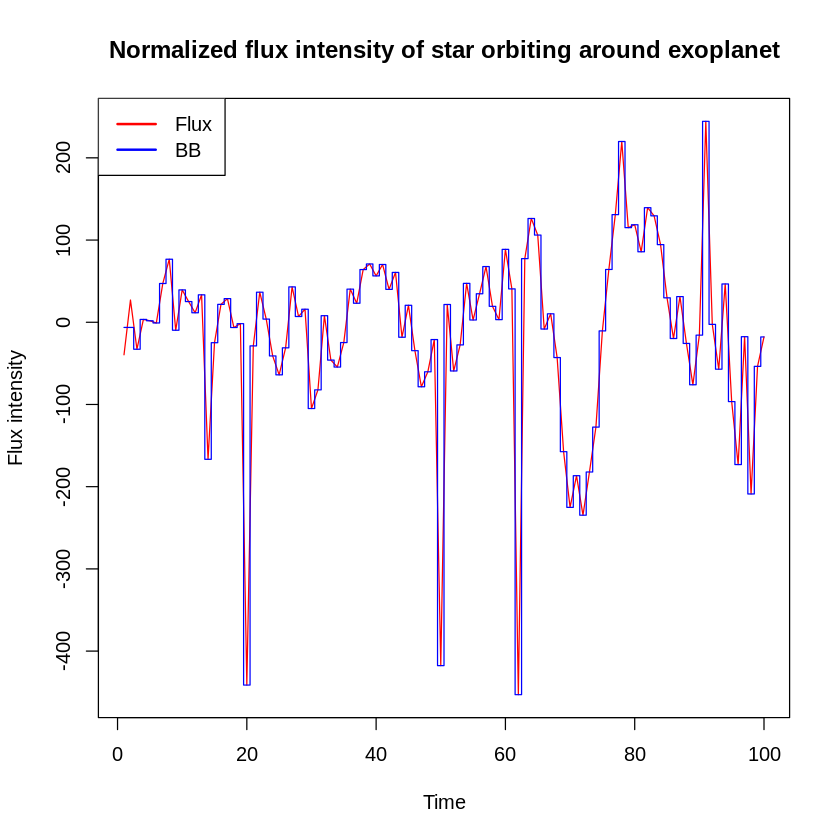

In [52]:
#counting mean over edges

edges = bayesian_blocks(data = data, data_type = 'PointMeasures')

steps = rep(0, length(edges))

for (K in seq(1:length(edges))){

    steps[K] = mean(data$x[data$t>=edges[K] & data$t<=edges[K+1]])
    if (K==(length(edges)-1)){break}
}

steps[length(edges)] = steps[length(edges)-1]

steps[length(edges)] = steps[length(edges)-1]
plot(data$t,data$x,col="red",density=60, main="Normalized flux intensity of star orbiting around exoplanet", type='l', xlab='Time', ylab='Flux intensity')
lines(edges, steps , type = "s", lwd = 1, col = "blue")
legend("topleft", legend = c("Flux","BB"), col = c("red", "blue"), lty = c(1, 1), lwd = c(2, 2))

## Conclusions and future developments

In the most general cases, the Bayesian Blocks algorithm implemented is able to efficiently identify the most important features in data while avoiding the computational burden of an exhaustive search. Nevertheless, when working on certain datasets characterized by high noise or sparse data points, the algorithm might struggle in capturing meaningful structures.

Some interesting future devolpments might consist in incorporating advanced techniques such as **Logistic Regression** to address challenges posed by unbalanced datasets. The algorithm could better handle imbalanced datasets where rare events are of utmost significance. This would enable Bayesian Blocks to provide more accurate event detection, bolstering its utility in a variety of fields, from astronomy to anomaly detection.